# Osborne Mine, Australia - Airborne total-field magnetic anomaly

This is a section of a survey acquired in 1990 by the Queensland Government, Australia. The data are good quality with approximately 80 m terrain clearance and 200 m line spacing. The anomalies are very visible and present interesting processing and modelling challenges, as well as plenty of literature about their geology. The section contains the total field magnetic anomalies associated with the Osborne Mine, Lightning Creek sill complex, and the Brumby prospect. 

**Source:** Geophysical Acquisition & Processing Section 2019. MIM Data from Mt Isa Inlier, QLD (P1029), magnetic line data, AWAGS levelled. Geoscience Australia, Canberra. http://pid.geoscience.gov.au/dataset/ga/142419

**License:** [CC-BY](http://pid.geoscience.gov.au/dataset/ga/142419)

## Notes

🚨 **WARNING:** 🚨 This notebook required \~9 Gb of RAM to run. The dataset is a bit large (\~3 Gb on disk and ~90 million points) and the GA provided netCDF file is not very useful for out-of-memory indexing since the latitude and longitude aren't properly set as coordinates. 

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pygmt
import pyproj

## Download the data

Use [Pooch](https://github.com/fatiando/pooch) to download the original data file to our computer.

In [2]:
fname = pooch.retrieve(
    url="http://dapds00.nci.org.au/thredds/fileServer/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/QLD/line/P1029/P1029-line-magnetic-AWAGS_MAG_2010.nc",
    known_hash="sha256:119b472da05365f0df4e9dc0b2d4b0e5c213705acb4f79efcaa07e1aeeb7242c",
)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")

size: 3096.630339 Mb


## Read the data

Use pandas to read the data.

In [3]:
data_nc = xr.open_dataset(fname)
data_nc

<xarray.Dataset>
Dimensions:            (point: 96100603, line: 11231)
Coordinates:
  * line               (line) float64 1.0 2.0 3.0 ... 1.123e+04 1.123e+04
Dimensions without coordinates: point
Data variables: (12/14)
    line_index         (point) float64 ...
    areaFlag           (line) float32 ...
    levelFlag          (line) float64 ...
    lineType           (line) float64 ...
    FID                (point) float64 ...
    altitude           (point) float64 ...
    ...                 ...
    mag_awagsLevelled  (point) float32 ...
    mag_microLevelled  (point) float32 ...
    mag_tieLevelled    (point) float64 ...
    latitude           (point) float64 ...
    longitude          (point) float64 ...
    crs                int8 ...
Attributes: (12/23)
    CreationTime:             Sun Dec 15 23:09:37 2019
    CreationMethod:           intrepid2netcdf.exe
    IntrepidSourceDataset:    ./mag_database_reformat_adjusted/intrepid/GSQP1...
    median_sample_spacing_m:  6.7
    geospatial_bounds:        POLYGON ((138.000707 -18.061092, 138.000733 -18...
    geospatial_lon_max:       141.34279740678033
    ...                       ...
    institution:              Commonwealth of Australia (Geoscience Australia)
    uuid:                     12ee23de-033c-44f2-8b63-932203d25f39
    Conventions:              CF-1.6, ACDD-1.3
    metadata_link:            http://pid.geoscience.gov.au/dataset/ga/142419
    keywords:                 AWAGS, Australia, Earth sciences, GADDS2.0, QLD...
    licence:                  CC BY 4.0 (C) Commonwealth of Australia (Geosci...

The fields we're interested in are:

* Coordinates which are in the GDA94 datum
* AWAGS leveled magnetic anomaly (since the observed field values aren't present)
* The terrain clearance (which is what I'm assuming `altitude` is since it can't be observation height)
* The line number in case we need to group points by line

We'll read these fields only into a `pandas.DataFrame` for easier slicing.

In [4]:
data_full = pd.DataFrame({
    "longitude": data_nc.longitude.data,
    "latitude": data_nc.latitude.data,
    "terrain_clearance_m": data_nc.altitude.data.astype(np.float32),
    "total_field_anomaly_nt": data_nc.mag_awagsLevelled.data.astype(np.float32),
    "flight_line": data_nc.line_index.data.astype(np.uint16),
})

Now we can cut the data to a smaller region containing only the anomalies we want. This will help make the file size smaller and operations faster for demonstrations and tutorials.

In [5]:
# West, East, South, North
region = (140 + 30 / 60, 140 + 50 / 60, -22 - 10 / 60, -21 - 45 / 60)
selection = vd.inside((data_full.longitude, data_full.latitude), region)
data = data_full[selection].reset_index(drop=True).copy()
data

longitude   latitude  terrain_clearance_m  total_field_anomaly_nt  \
0       140.664104 -21.868339            80.699997             -124.284653   
1       140.664018 -21.868339            80.599998             -124.181824   
2       140.663932 -21.868338            80.599998             -124.069214   
3       140.663847 -21.868338            80.500000             -123.946846   
4       140.663762 -21.868338            80.400002             -123.834244   
...            ...        ...                  ...                     ...   
990982  140.507566 -21.870240            79.269997              -66.726227   
990983  140.507566 -21.870299            79.400002              -66.385582   
990984  140.507567 -21.870357            79.580002              -66.055672   
990985  140.507568 -21.870412            79.790001              -65.685265   
990986  140.507569 -21.870470            80.070000              -65.334846   

        flight_line  
0              5576  
1              5576  
2              5576  
3              5576  
4              5576  
...             ...  
990982        10166  
990983        10166  
990984        10166  
990985        10166  
990986        10166  

[990987 rows x 5 columns]

## Convert the horizontal coordinates

Now that we have less data, we can convert the coordinates into WGS84 for uniformity with our other datasets. 

In [6]:
gda_to_wgs = pyproj.Transformer.from_crs("epsg:4283", "epsg:4326", always_xy=True)
longitude, latitude = gda_to_wgs.transform(
    data.longitude.values, 
    data.latitude.values,
)
data = data.assign(longitude=longitude, latitude=latitude)
data

longitude   latitude  terrain_clearance_m  total_field_anomaly_nt  \
0       140.664111 -21.868325            80.699997             -124.284653   
1       140.664025 -21.868325            80.599998             -124.181824   
2       140.663940 -21.868325            80.599998             -124.069214   
3       140.663855 -21.868325            80.500000             -123.946846   
4       140.663769 -21.868324            80.400002             -123.834244   
...            ...        ...                  ...                     ...   
990982  140.507573 -21.870226            79.269997              -66.726227   
990983  140.507574 -21.870285            79.400002              -66.385582   
990984  140.507575 -21.870344            79.580002              -66.055672   
990985  140.507576 -21.870398            79.790001              -65.685265   
990986  140.507577 -21.870457            80.070000              -65.334846   

        flight_line  
0              5576  
1              5576  
2              5576  
3              5576  
4              5576  
...             ...  
990982        10166  
990983        10166  
990984        10166  
990985        10166  
990986        10166  

[990987 rows x 5 columns]

## Calculate the observation height

The data only contain the terrain clearance information, so we won't know the height of observations unless we know the height of topography. 

We can use PyGMT to get a high-resolution grid of SRTM topography (as orthometric height) and then interpolate the values onto our data locations. We'll get a slightly larger grid than our data region to avoid edge effects during interpolation.

In [7]:
srtm = vd.grid_to_table(pygmt.grdcut("@earth_relief_01s_g", region=vd.pad_region(region, 2 / 60)))
srtm

lat         lon      z
0       -22.200000  140.466667  294.0
1       -22.200000  140.466944  294.0
2       -22.200000  140.467222  295.0
3       -22.200000  140.467500  295.0
4       -22.200000  140.467778  294.0
...            ...         ...    ...
2508776 -21.716667  140.865556  346.0
2508777 -21.716667  140.865833  350.0
2508778 -21.716667  140.866111  356.0
2508779 -21.716667  140.866389  359.0
2508780 -21.716667  140.866667  360.0

[2508781 rows x 3 columns]

Now that we have the topography, we'll do the interpolation using a fast nearest-neighbor method. Since we only have access to a Cartesian version of the interpolation, we need to first project the input coordinates (using a Mercator projection for simplicity).

In [8]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

nearest = vd.ScipyGridder(method="nearest")
nearest.fit(projection(srtm.lon.values, srtm.lat.values), srtm.z)
topography = nearest.predict(projection(data.longitude.values, data.latitude.values))

data = data.assign(
    height_orthometric_m=topography + data.terrain_clearance_m,
)
data

longitude   latitude  terrain_clearance_m  total_field_anomaly_nt  \
0       140.664111 -21.868325            80.699997             -124.284653   
1       140.664025 -21.868325            80.599998             -124.181824   
2       140.663940 -21.868325            80.599998             -124.069214   
3       140.663855 -21.868325            80.500000             -123.946846   
4       140.663769 -21.868324            80.400002             -123.834244   
...            ...        ...                  ...                     ...   
990982  140.507573 -21.870226            79.269997              -66.726227   
990983  140.507574 -21.870285            79.400002              -66.385582   
990984  140.507575 -21.870344            79.580002              -66.055672   
990985  140.507576 -21.870398            79.790001              -65.685265   
990986  140.507577 -21.870457            80.070000              -65.334846   

        flight_line  height_orthometric_m  
0              5576            366.700012  
1              5576            366.600006  
2              5576            366.600006  
3              5576            366.500000  
4              5576            366.399994  
...             ...                   ...  
990982        10166            382.269989  
990983        10166            382.399994  
990984        10166            382.580017  
990985        10166            382.790009  
990986        10166            382.070007  

[990987 rows x 6 columns]

## Plot the data 

Make a quick plot to make sure the data look OK. This plot will be used as a preview of the dataset.

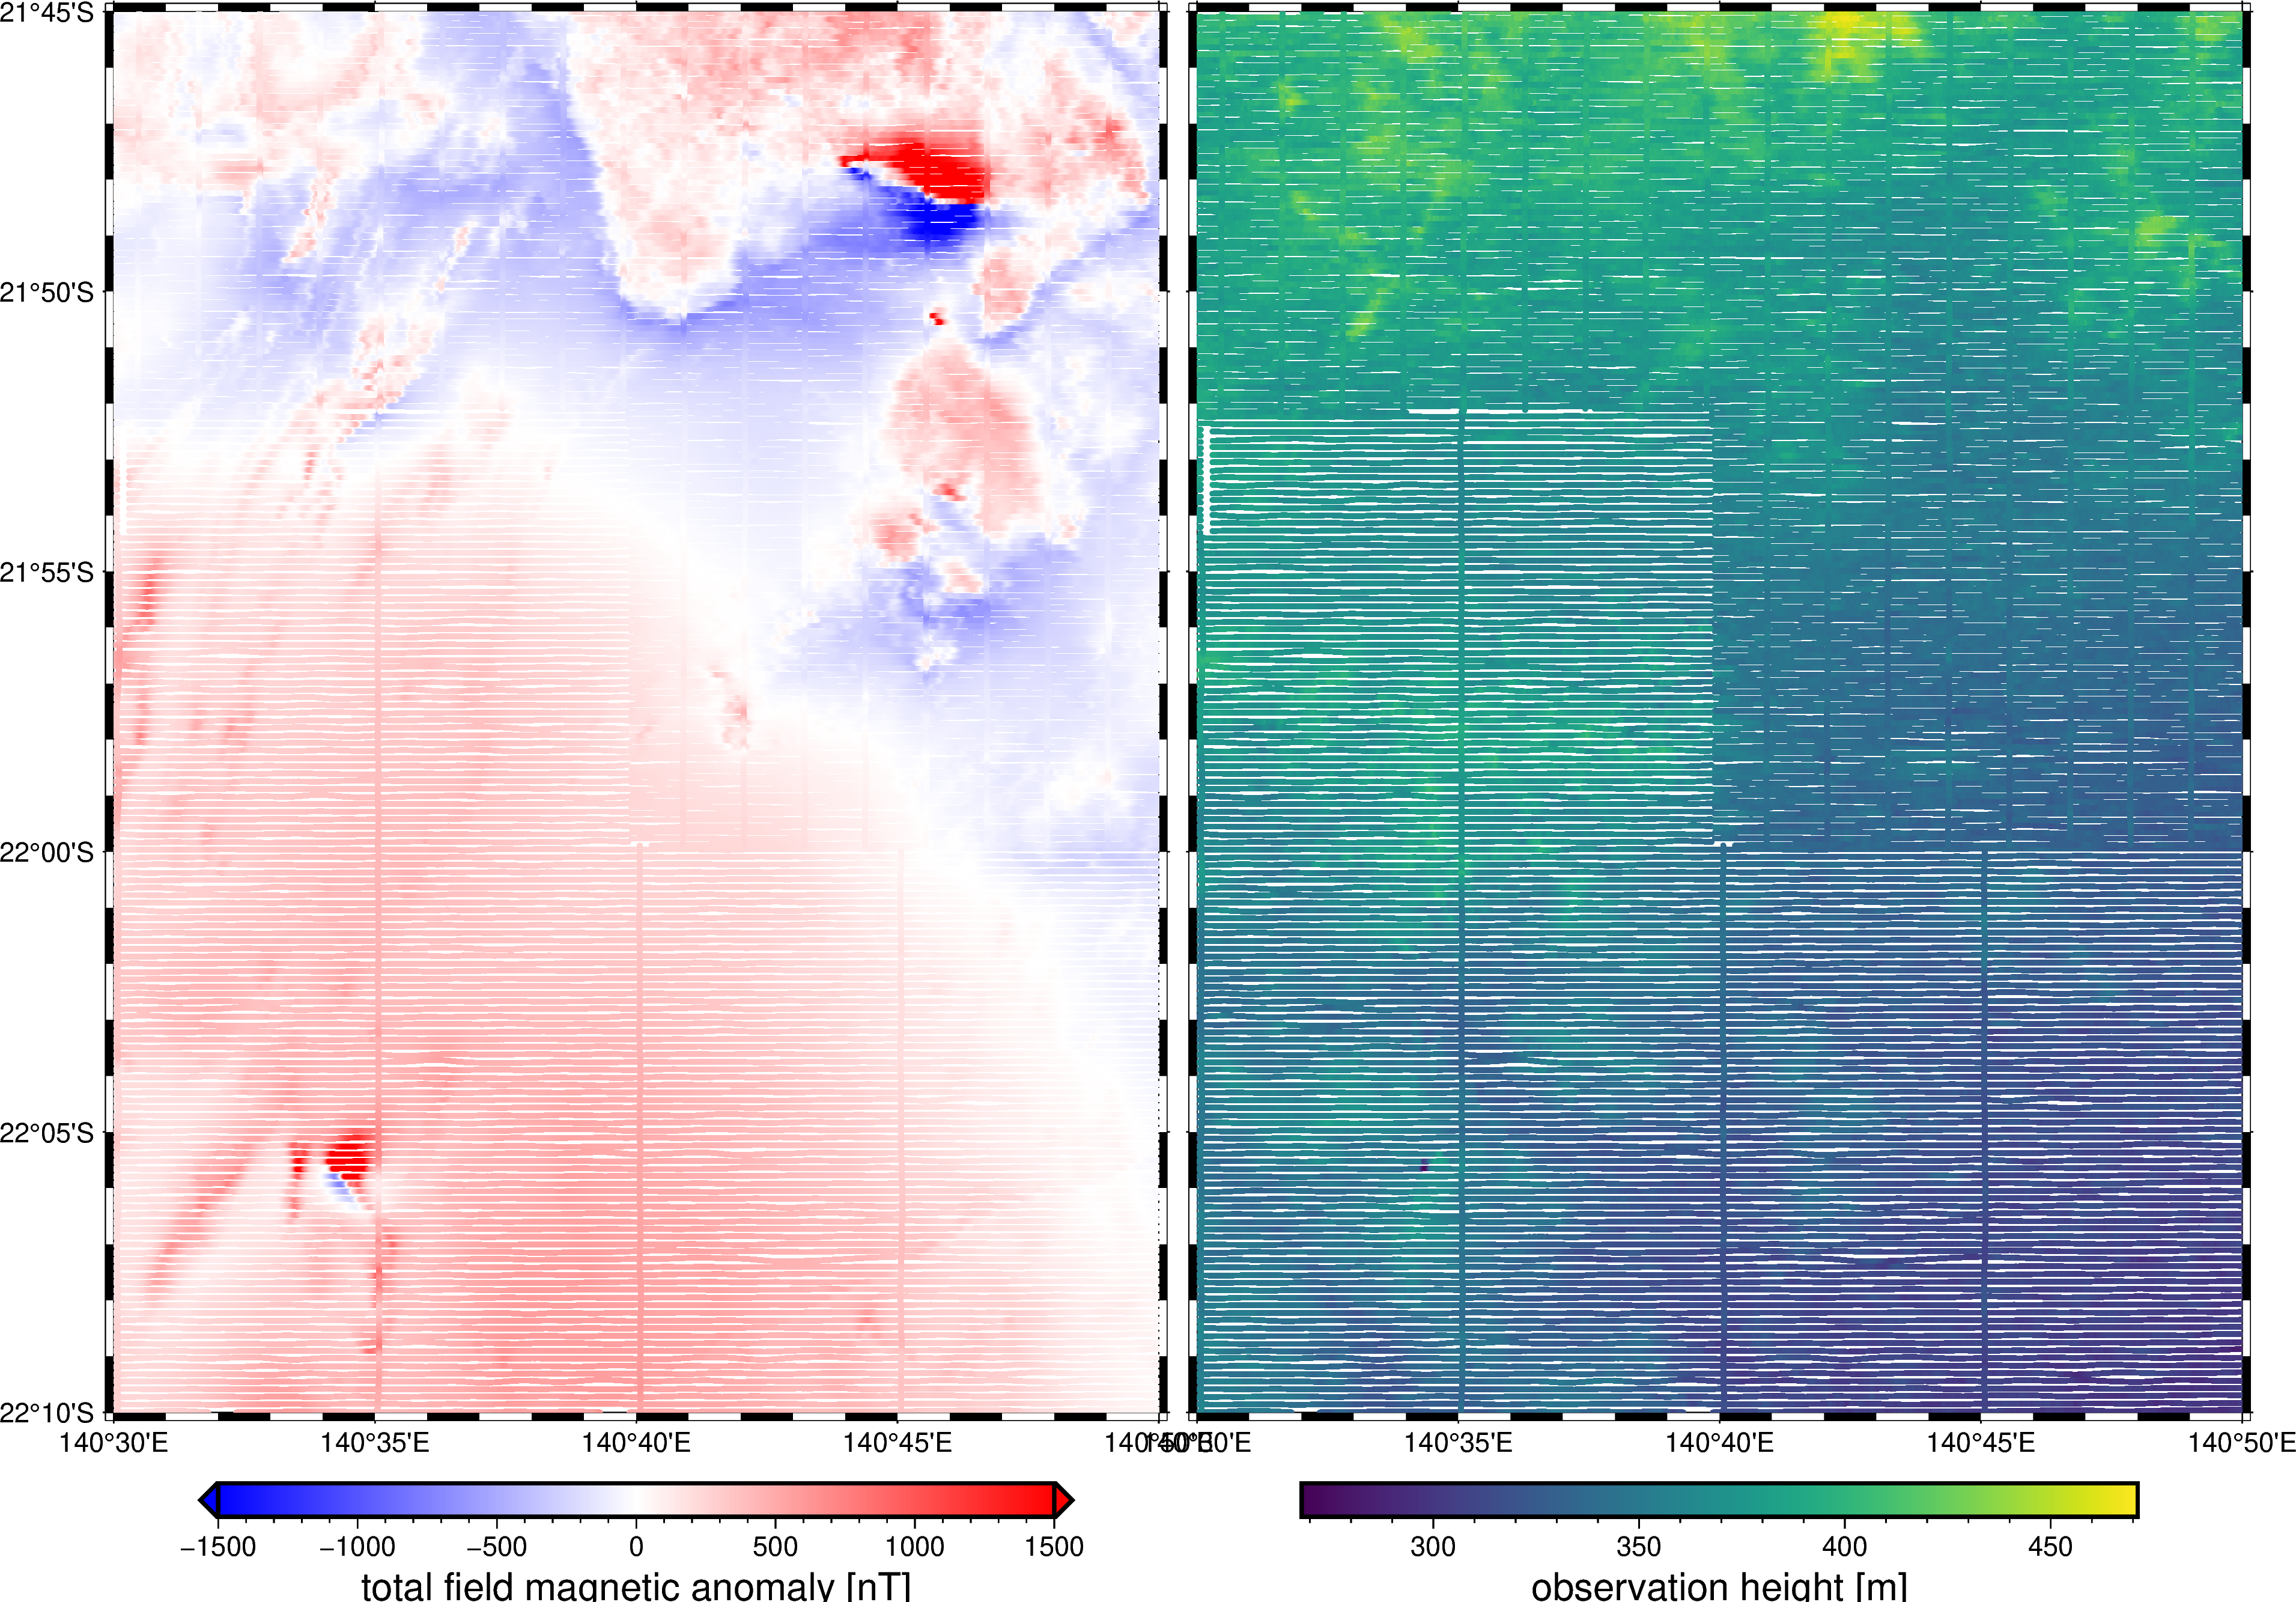

In [9]:
fig = pygmt.Figure()
with fig.subplot(
    nrows=1,
    ncols=2,
    figsize=("30c", "20c"),
    sharey="l",  # shared y-axis on the left side
    frame="WSrt",
):
    with fig.set_panel(0):
        fig.basemap(projection="M?", region=region, frame="af")
        scale = 1500
        pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            color=data.total_field_anomaly_nt,
            style="c0.075c",
            cmap=True,
        )
        fig.colorbar(
            frame='af+l"total field magnetic anomaly [nT]"', 
            position="JBC+h+o0/1c+e",
        )
    with fig.set_panel(1):
        fig.basemap(projection="M?", region=region, frame="af")
        pygmt.makecpt(cmap="viridis", series=[data.height_orthometric_m.min(), data.height_orthometric_m.max()])
        fig.plot(
            x=data.longitude,
            y=data.latitude,
            color=data.height_orthometric_m,
            style="c0.075c",
            cmap=True,
        )
        fig.colorbar(
            frame='af+l"observation height [m]"', 
            position="JBC+h+o0/1c",
        )
fig.savefig("preview.jpg", dpi=200)
fig.show(width=800)

The Osborne Mine is the small dipolar anomaly in the Southwest of the map. The Lightning Creek complex is the large anomaly in the Northeast.

## Export

Make a separate DataFrame to export to a compressed CSV. The conversion is needed to specify the number of significant digits to preserve in the output. Setting this along with the LZMA compression can help reduce the file size considerably. Not all fields in the original data need to be exported.

For our purposes, 1 m precision should be more than enough for coordinates and topography and 1 nT for the magnetic anomaly (~0.1% of the anomaly amplitudes).

In [10]:
export = pd.DataFrame({  
    "flight_line": data.flight_line, 
    "longitude": data.longitude.map(lambda x: "{:.5f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.5f}".format(x)),    
    "height_orthometric_m": data.height_orthometric_m.map(lambda x: "{:.0f}".format(x)),   
    "total_field_anomaly_nt": data.total_field_anomaly_nt.map(lambda x: "{:.0f}".format(x)), 
})
export

flight_line  longitude   latitude height_orthometric_m  \
0              5576  140.66411  -21.86833                  367   
1              5576  140.66403  -21.86832                  367   
2              5576  140.66394  -21.86832                  367   
3              5576  140.66385  -21.86832                  366   
4              5576  140.66377  -21.86832                  366   
...             ...        ...        ...                  ...   
990982        10166  140.50757  -21.87023                  382   
990983        10166  140.50757  -21.87029                  382   
990984        10166  140.50758  -21.87034                  383   
990985        10166  140.50758  -21.87040                  383   
990986        10166  140.50758  -21.87046                  382   

       total_field_anomaly_nt  
0                        -124  
1                        -124  
2                        -124  
3                        -124  
4                        -124  
...                       ...  
990982                    -67  
990983                    -66  
990984                    -66  
990985                    -66  
990986                    -65  

[990987 rows x 5 columns]

Save the data to a file and calculate the size and MD5/SHA256 hashes.

In [11]:
output = "osborne-magnetic.csv.xz"
export.to_csv(output, index=False)
print(f"file: {output}")
print(f"size: {os.path.getsize(output) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(output, alg=alg)}")

file: osborne-magnetic.csv.xz
size: 2.214076 Mb
md5:b26777bdde2f1ecb97dda655c8b1cf71
sha256:12d4fc2c98c71a71ab5bbe5d9a82dd263bdbf30643ccf7832cbfec6249d40ded


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [12]:
data_reloaded = pd.read_csv(output)
data_reloaded

flight_line  longitude  latitude  height_orthometric_m  \
0              5576  140.66411 -21.86833                   367   
1              5576  140.66403 -21.86832                   367   
2              5576  140.66394 -21.86832                   367   
3              5576  140.66385 -21.86832                   366   
4              5576  140.66377 -21.86832                   366   
...             ...        ...       ...                   ...   
990982        10166  140.50757 -21.87023                   382   
990983        10166  140.50757 -21.87029                   382   
990984        10166  140.50758 -21.87034                   383   
990985        10166  140.50758 -21.87040                   383   
990986        10166  140.50758 -21.87046                   382   

        total_field_anomaly_nt  
0                         -124  
1                         -124  
2                         -124  
3                         -124  
4                         -124  
...                        ...  
990982                     -67  
990983                     -66  
990984                     -66  
990985                     -66  
990986                     -65  

[990987 rows x 5 columns]

Make the figure again but don't save it to a file this time.

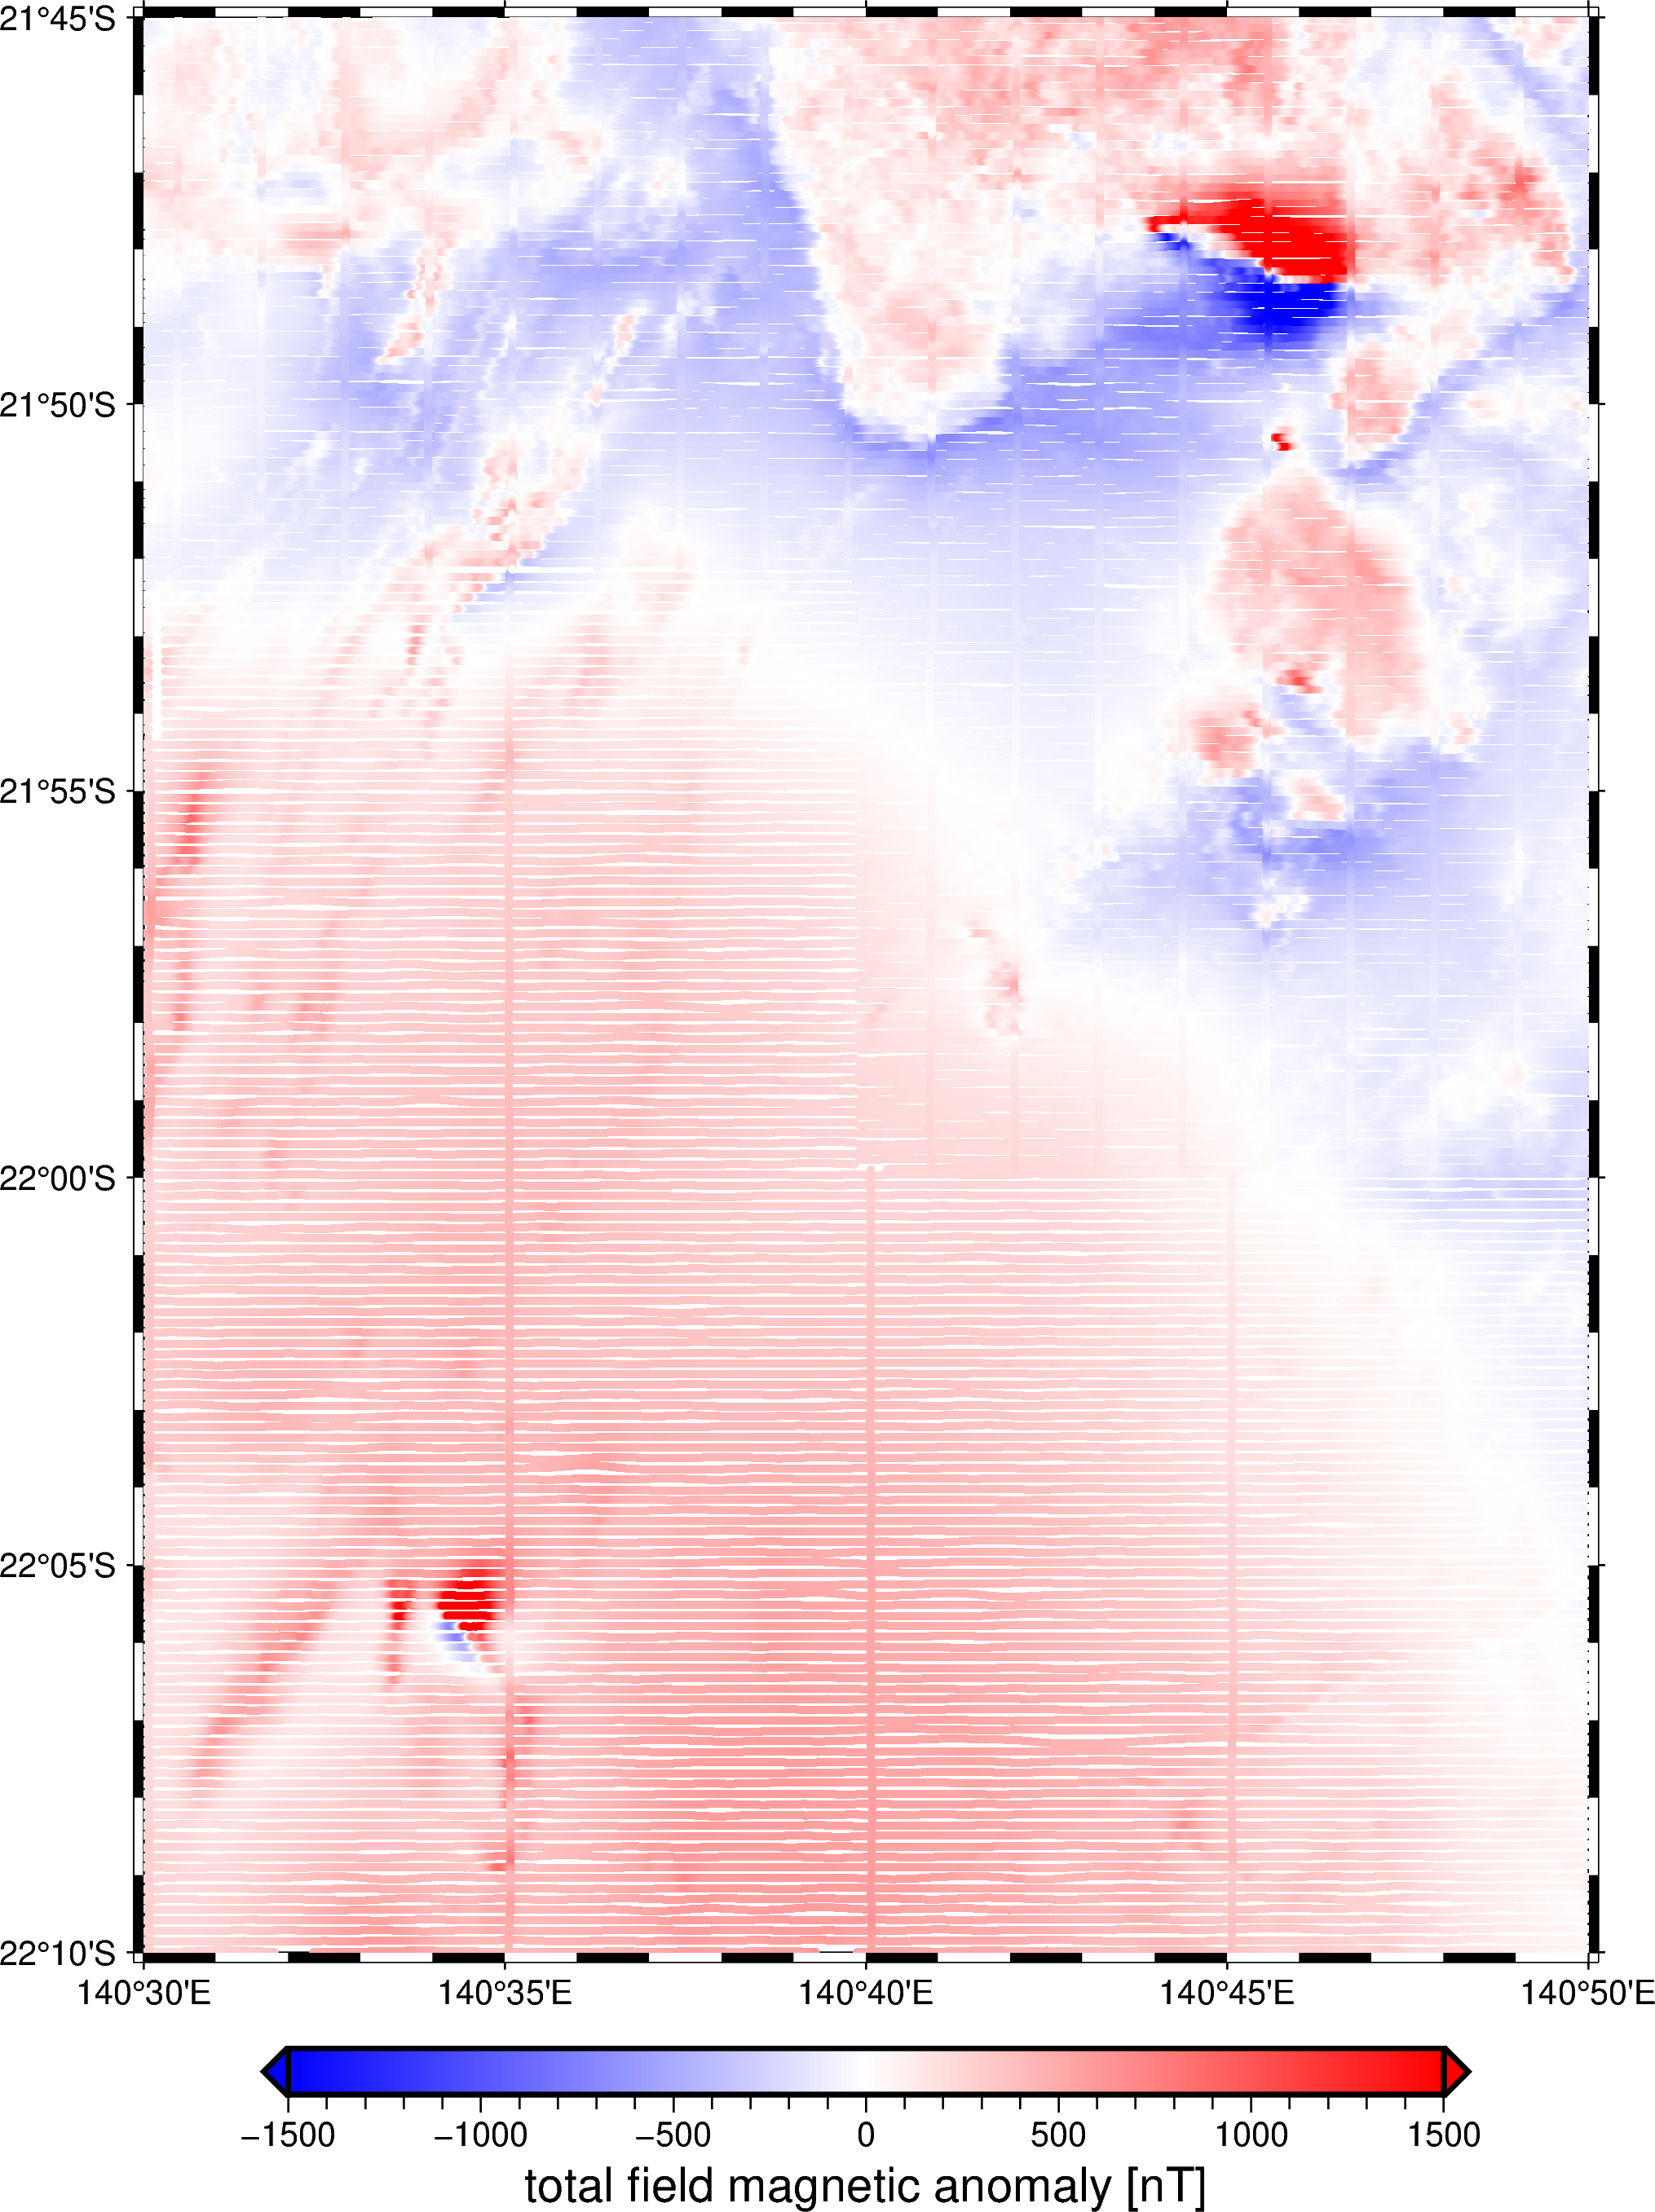

In [13]:
fig = pygmt.Figure()
fig.basemap(projection="M15c", region=region, frame="af")
scale = 1500
pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
fig.plot(
    x=data_reloaded.longitude,
    y=data_reloaded.latitude,
    color=data_reloaded.total_field_anomaly_nt,
    style="c0.075c",
    cmap=True,
)
fig.colorbar(
    frame='af+l"total field magnetic anomaly [nT]"', 
    position="JBC+h+o0/1c+e",
)
fig.show()